# Cannabis Strain Investigation (CSI)

I couldn't find a dataset with most of the features I was looking for, so I wrote code to webscrape cannaconnection. 

There are ~1600 strains on this website, I've written three blocks of code to help get the information I need. 

    Block 1. Scrape through each page a-z and write each https: link to one text file. 
    
    Block 2. Open the text file and write a csv file for each strain with all the list features and growing 
    properties for each strain.
    
    Block 3. Read in every CSV file into a single dataframe that can be worked with later. 

# Table of Contents

**Part 1: [Webscraping Code](#webscrape)**
    
    1.1 Code Block One
    
    1.2 Code Block Two
    
    1.3 Code Block Three

**Part 2: [EDA](#eda)**

    2.1 Strain Names
   
    2.2 Plant Types
   
    2.3 THC & CBD Content
   
    2.4 Flavours
   
    2.5 Effects
   
    2.6 Growing Properties
   
    2.7 Preprocessing
   
**Part 3: [Modeling](#model)**

    3.1 Baseline Testing - LogisticRegression, SVM, KNN, DecisionTree
   
    3.2 Hyper-Optimization - Pipeline, GridSearch


In [13]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Web scraping tools
import requests
from bs4 import BeautifulSoup

# For adding delays, to avoid spamming requests
import time

# import re for regex
import re
# import a-z to loop through
from string import ascii_lowercase

## Webscraping
<a id=webscrape></a>

### Code Block One

##### Obtain all the weblinks on cannaconnection from A-Z

The code will open each page from a-z and scrape the weblink for every strain storing the https in a text file. 


In [ ]:
# open text file and append results for each a-z letter. 
weed_file = open("weed_file.txt", 'a+')

# loop through the alphabet a-z
for c in ascii_lowercase:
    
    # get a response for each letter
    response = requests.get(f"https://www.cannaconnection.com/strains?show_char={c}")
    
    # start the soup 
    soup = BeautifulSoup(response.content, 'html5lib')
    
    # find the strain lists
    strains = soup.find_all(class_='strains-list')
    
    # find elements that match 'a href' criterion and assign them to a variable
    a = strains[0].find_all('a', text=True)
    
    # pull each item and append the result to our text file
    for link in a[0:]:
        b = a[0].findAll(text=True)
        for item in b[0:]:
            if item == "\n":
                b.remove(item)
        output = link.get('href').encode('ascii', errors='ignore').decode()
        # write to and create a new line
        weed_file.write(output + "\n")
        
# close the text file        
weed_file.close()

### Code Block Two


Now that I have all the weblinks for each strain, I need to run this block of code to scrape each strain's features and growing properties. 

1. Open our text file from part 1. 
2. Read through each line and send a request using BeautifulSoup


In [ ]:
# open the text file again.
weedfile = open('weed_file.txt', 'r')

# read each line in the file
lines = weedfile.readlines()

# loop through and send a web request to extract the features we need.
for line in lines[0:]:
    # strip out extra text
    line = line.replace('\n', '')
    new_response = requests.get(line)
    # start the soup and find the parts we need
    soup = BeautifulSoup(new_response.content, 'html5lib')
    a = soup.find_all(class_='primary_block post-content')
    b = soup.find_all(class_='data-sheet')
    c = b[0].find_all(class_='feature-value')
    d = b[1].find_all('dd')
    
    #get strain title
    title = a[0].find('h1').text
    
    # get the feature list and append to list
    features = []
    for f in c:
        features.append(f.text.strip())
    
    # get all the growing traits and append to list
    growing = []
    for g in d:
        growing.append(g.text.strip())
    
    # for the same strain, write the results to a new csv file
    linearray = line.split("/")
    print("Scraping " + linearray[3].title())
    url = "https://www.cannaconnection.com/strains/" + linearray[4]
    print("URLSCRAPE " + url)
    strain = linearray[4]
    
    # create file url in results folder
    fileurl = "datafiles/results/"+strain+".csv"
    # write title, feature list and growing list
    array = [title, features, growing]
    file = open(fileurl, "a+")
    for elem in array[0:]:
        file.write(str(elem) + "\n")
    # close file, move on to next    
    file.close()
    
# close master weed file
weedfile.close()

### Code Block 3

I have all of my individual CSV files saved to the results folder. 
This next block of code will read in all csv files created in code block 2 into a dataframe that I can work with later. 

In [ ]:
import pandas as pd
import glob

# set up path to search on my computer
path = r'/Users/lizzy/Desktop/cannabis_project/datafiles/results/'
weed_files = glob.glob(path + "/*.csv")

In [ ]:
# empty dataframe
weed_df = pd.DataFrame()

# read in each file and append the information to our dataframe
for file in weed_files:
    strain_row = pd.read_csv(file, sep='\[]', engine='python')
    weed_df = weed_df.append(strain_row)

In [ ]:
# reset the index to 0
weed_df.reset_index(inplace=True)

In [ ]:
# sort by strain name
weed_df.sort_values(by='index', inplace=True)

In [ ]:
# rename columns to drop null column
weed_df.columns=['strain', 'features', 'growing', 'drop']

In [ ]:
# drop null column at the end of the dataframe. 
weed_df.drop('drop', axis=1, inplace=True)

In [ ]:
# remove brackets from features and growing columns. 
weed_df['features'] = weed_df['features'].str.replace('\[', '').str.replace('\]', '').astype(str)
weed_df['growing'] = weed_df['growing'].str.replace('\[', '').str.replace('\]', '').astype(str)

In [ ]:
# split each feature for every strain into its own column. 
features = pd.DataFrame(weed_df['features'].str.split(',').tolist())

In [ ]:
# split each growing trait for every strain into its own column
growing_traits = pd.DataFrame(weed_df['growing'].str.split(',').tolist())

In [ ]:
# merge features and growing traits with strain name.
weed_df = pd.merge(weed_df, features, how='left', left_index=True, right_index=True).drop('features', axis=1)
# drop extra column
growing_traits.drop(4, axis=1, inplace=True)
# rename columns 
growing_traits.columns=['difficulty', 'grow_type', 'growing_time', 'yield_month']

In [ ]:
# merge growing traits to final df
weed_df = pd.merge(weed_df, growing_traits, how='left', left_index=True, right_index=True).drop('growing', axis=1)
# reset the index
weed_df.reset_index(drop=True,inplace=True)
# export to excel for cleaning
weed_df.to_excel('datasets/cannaconnection.xlsx')

I exported the dataframe to excel to manipulate the cells faster. Using Excel will allow me to see the entire dataset unobstructed and I can get into a more workable format before loading it back into pandas.

# EDA
<a id=eda></a>

After working on the file in Excel, I'm going to load it back into pandas to do some EDA and visualizations before modelling. 

In [2]:
# import tools for word clouds
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# read in the new dataset. 
cc_df = pd.read_excel('datafiles/clean_cannaconnection.xlsx')

# check the first 5 rows
cc_df.head()

# creating a working copy so that I can easily get the original data if I need to later.
working_df = cc_df.copy()

# check out dataframe
working_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   strain           1617 non-null   object 
 1   type             1617 non-null   object 
 2   thc              1617 non-null   float64
 3   cbd              1617 non-null   float64
 4   flavour1         1617 non-null   object 
 5   flavour2         1608 non-null   object 
 6   flavour3         1379 non-null   object 
 7   flavour4         667 non-null    object 
 8   effect1          1617 non-null   object 
 9   effect2          1612 non-null   object 
 10  effect3          1516 non-null   object 
 11  effect4          1077 non-null   object 
 12  effect5          369 non-null    object 
 13  grow_type        1617 non-null   object 
 14  weeks_to_flower  1617 non-null   float64
dtypes: float64(3), object(12)
memory usage: 189.6+ KB


In [4]:
# aggregate thc, cbd and weeks to flower columns. 
working_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
thc,1617.0,0.159985,0.050058,0.000,0.120,0.160,0.21,0.28
cbd,1617.0,0.020313,0.046609,0.001,0.001,0.001,0.01,0.22
weeks_to_flower,1617.0,9.027520,1.212692,6.000,8.500,9.000,9.50,16.00


The average THC content is 15% while the average CBD content is only 2%. The range of levels goes as high as 28% and 22% respectively. 

The average number of weeks it takes for a plant to flower is 9.

In [5]:
# Check null values.
working_df.isna().sum()

strain                0
type                  0
thc                   0
cbd                   0
flavour1              0
flavour2              9
flavour3            238
flavour4            950
effect1               0
effect2               5
effect3             101
effect4             540
effect5            1248
grow_type             0
weeks_to_flower       0
dtype: int64

I've decide to not fill the null values because when I convert the dataframe to dummy variables later, these cells will be ignored and I won't have to deal with the extra columns. 

### Cleaning and Visualizations
Now I'm going to work through each column to set it up the dataframe so I can model. 

I will also do some visualizations during this process as well. 

In [6]:
# set the flavour and effects columns to strings
working_df.iloc[:, 4:13] = working_df.iloc[:, 4:13].astype(str)

In [7]:
# colour palettes for graphs
thc_colors=['goldenrod', 'firebrick', 'orange']
cbd_colors=['dodgerblue', 'darkcyan', 'magenta']
plant_colors=['mediumseagreen', 'crimson', 'dodgerblue']

### Strain Names


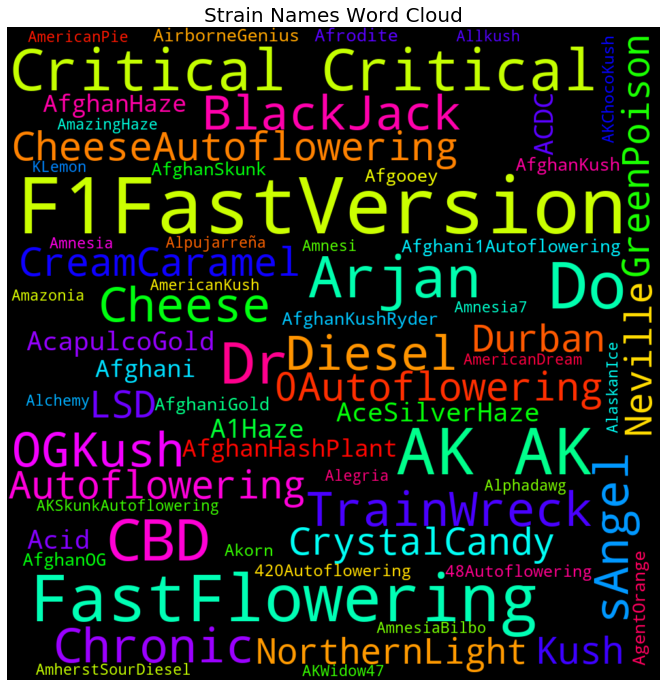

In [8]:
# word cloud on strain names. 
# break up each strain and join into one list
strains =  " ".join(working_df['strain'])
   
# create word cloud
wordcloud = WordCloud(width=1000,
                      height=1000,
                      colormap='hsv',
                      min_font_size=20,
                      max_font_size=120,
                      relative_scaling=0.5).generate(strains)

# set image properties
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# add title 
plt.title("Strain Names Word Cloud", fontsize=20)
plt.show()

Some strain names seem to have repeating words such as `critical`, `OG`, and `kush` among others. 

### Plant Types


In [9]:
# check out the value counts of each plant type. 
working_df['type'].value_counts()

indica    710
sativa    474
hybrid    433
Name: type, dtype: int64

In [10]:
print('% Indica plants: ', (710/1617*100))
print("% Sativa plants: ", (474/1617*100))
print("% Hybrid plants: ", (433/1617*100))

% Indica plants:  43.90847247990105
% Sativa plants:  29.313543599257883
% Hybrid plants:  26.777983920841063


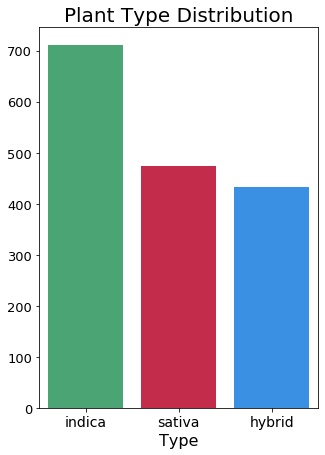

In [14]:
# Visualize the distributions
plant_count = working_df['type'].value_counts().values

plant_types = working_df['type'].value_counts().index

# plot distribution of plant types
colors = plant_colors
plt.figure(figsize=(5,7))
sns.barplot(plant_types, plant_count, palette=colors)
plt.xlabel("Type", size=16)
plt.xticks(size=14)
plt.yticks(size=13)
plt.title('Plant Type Distribution', size=20)
plt.show()

##### Analysis - Plant Type

This dataset has ~ 1600 strains, with a decent distribution across the three classes. The other datasets I've found had substantially more hybrid strains compared to indica and sativs. 1600 strains seems substantial to work with for modeling. I should be able to split the dataset into train, validation and test sets to avoid data leakage when performing hyper-optimization. 

### THC & CBD


(These values are in percentages.)

In [15]:
# explore mean, max, min, median values of plant types and thc, cbd and flowering length
working_df.groupby('type').agg(['mean', 'max', 'min', 'median'])

thc                          cbd                      \
            mean   max   min median      mean   max    min median   
type                                                                
hybrid  0.158637  0.27  0.01   0.15  0.020697  0.22  0.001  0.001   
indica  0.155725  0.28  0.01   0.15  0.020718  0.22  0.001  0.001   
sativa  0.167595  0.27  0.00   0.18  0.019354  0.22  0.001  0.001   

       weeks_to_flower                    
                  mean   max  min median  
type                                      
hybrid        8.796767  12.5  6.5    8.5  
indica        8.630282  13.0  6.0    8.5  
sativa        9.833333  16.0  7.0    9.5

/Users/lizzy/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


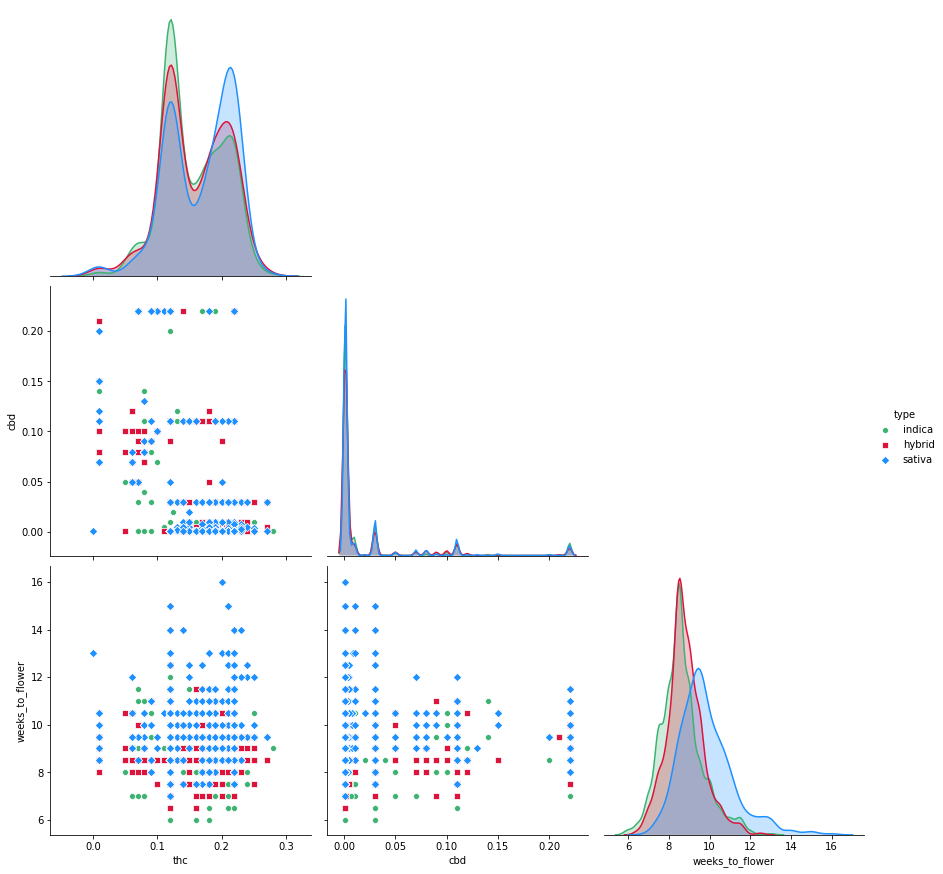

In [16]:
# check if any relationship between numerical columns
sns.pairplot(working_df, 
             hue='type',
             palette=plant_colors, 
             height=3,
             corner=True,
             markers=['o','s','D'], 
             diag_kind='kde' )
plt.show()

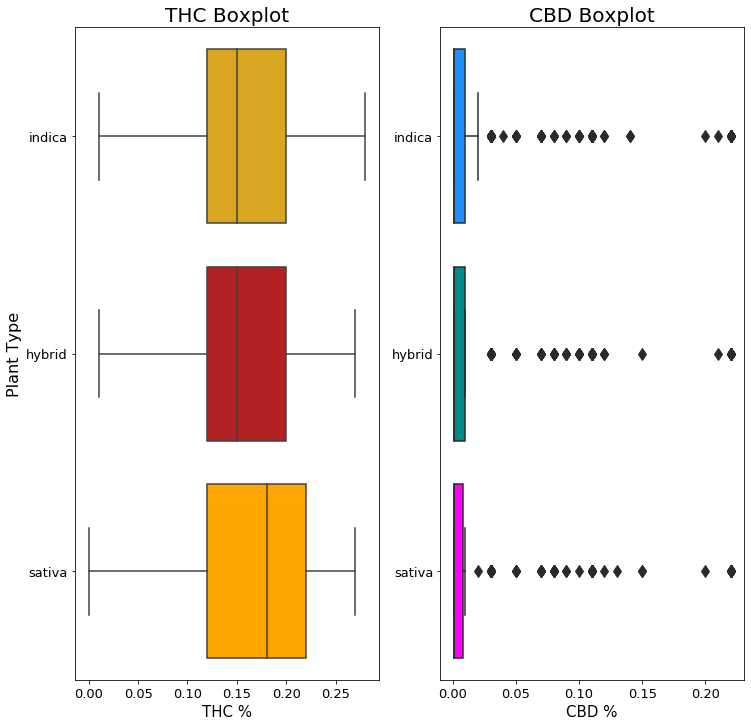

In [17]:
# box plot of ratings across types

# create figure
plt.subplots(1,2, figsize=(12,12))

# create THC plot
plt.subplot(1,2,1)
sns.boxplot(x='thc',
            y='type',
            data=working_df,
            palette=thc_colors,
            fliersize=9,
            whis=1.5,
            saturation=1.0)

# set titles and labels
plt.title('THC Boxplot', fontsize=20)
plt.xticks(fontsize=13)
plt.xlabel('THC %', fontsize=15)
plt.ylabel("Plant Type", fontsize=16)
plt.yticks(fontsize=13)

# create CBD plot
plt.subplot(1,2,2)
sns.boxplot(x='cbd',
            y='type',
            data=working_df,
            palette=cbd_colors,
            fliersize=9,
            whis=1.5,
            saturation=1.0)

# set title and labels
plt.title('CBD Boxplot', fontsize=20)
plt.xticks(fontsize=13)
plt.xlabel('CBD %', fontsize=15)
plt.ylabel(ylabel=None)
plt.yticks(fontsize=13)

plt.show()

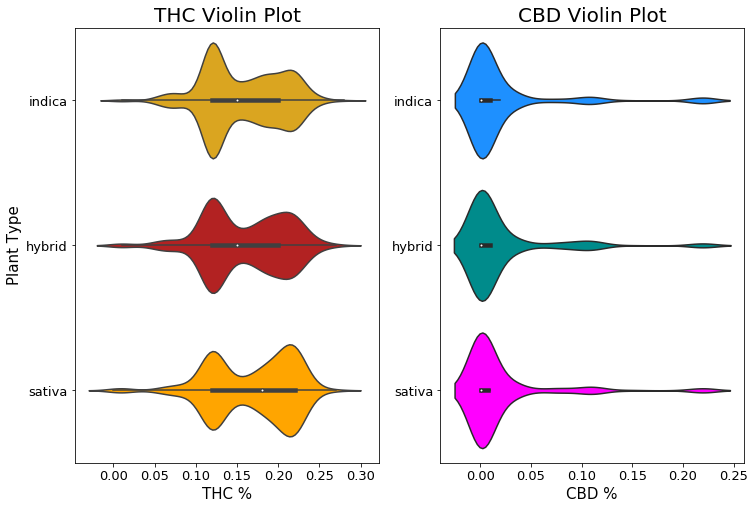

In [18]:
# Violin plot of ratings across types
# set up color palette

# create figure
plt.subplots(1,2, figsize=(12,8), sharey=True)

# create THC violin plot 
plt.subplot(1,2,1)
sns.violinplot(x='thc',
            y='type',
            data=working_df,
            palette=thc_colors,
            fliersize=9,
            whis=1.5,
            saturation=1.0)

# set title and labels
plt.title('THC Violin Plot', fontsize=20)
plt.xticks(fontsize=13)
plt.xlabel('THC %', fontsize=15)
plt.yticks(fontsize=13)
plt.ylabel('Plant Type', fontsize=15)
           
# create CBD violin plot
plt.subplot(1,2,2)
sns.violinplot(x='cbd',
               y='type', 
               data=working_df,
               palette=cbd_colors,
               fliersize=9,
               whis=2.0,
               saturation=1.0)

# set title and labels
plt.title('CBD Violin Plot', fontsize=20)
plt.xticks(fontsize=13)
plt.xlabel('CBD %', fontsize=15)
plt.yticks(fontsize=13)
plt.ylabel(ylabel=None,fontsize=15)
plt.show()

### Flavours


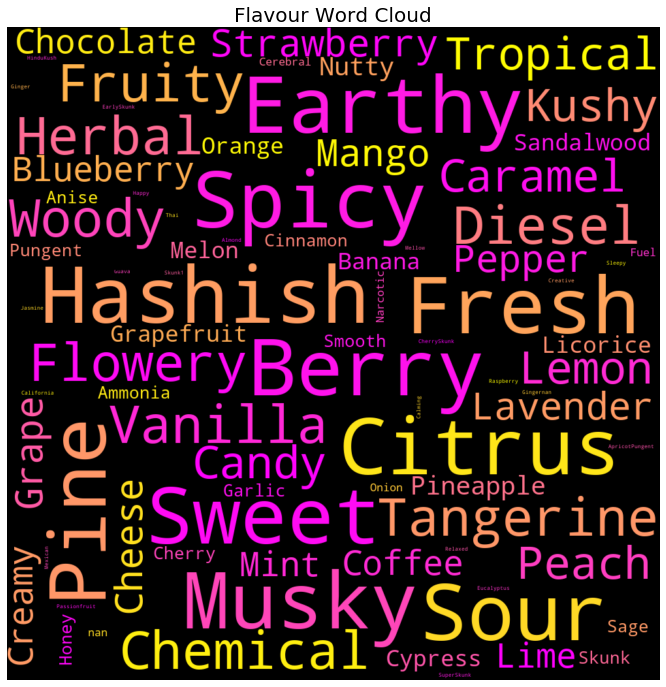

In [19]:
# find unique effects in each column
text1 = " ".join(working_df['flavour1'].unique())
text2 = " ".join(working_df['flavour2'].unique())
text3 = " ".join(working_df['flavour3'].unique())
text4 = " ".join(working_df['flavour4'].unique())

# group text strings together to produce wordcloud
text = (text1 + text2 + text3 + text4)
# setup stopwords
stopwords = set(STOPWORDS)
stopwords.update(["None","none"])

# create word cloud for effects words
wordcloud = WordCloud(width=1000,
                      height=1000,
                      stopwords=stopwords,
                      colormap='spring',
                      relative_scaling=1.0,
                      max_font_size=120).generate(text)

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Flavour Word Cloud", fontsize=20)
plt.axis("off")
plt.show()

In [20]:
# create crosstabs of each effect column to sum the counts
ct_f1 = pd.crosstab(working_df['type'], working_df['flavour1'])
ct_f2 = pd.crosstab(working_df['type'], working_df['flavour2'])
ct_f3 = pd.crosstab(working_df['type'], working_df['flavour3'])
ct_f4 = pd.crosstab(working_df['type'], working_df['flavour4'])

# put the crosstab results into a dataframe
flavour_type_df = pd.concat([ct_f1, ct_f2, ct_f3, ct_f4], axis=0,\
                             ignore_index=False,\
                             keys=['1','2','3','4'],\
                             names=['Flavour', 'Plant Type'])

# drop the NaN column
flavour_type_df.drop(['nan'], axis=1, inplace=True)

# fill NaN remaining as 0
flavour_type_df.fillna(0, inplace=True)

# sum the totals for each flavour
flavour_total = flavour_type_df.groupby('Flavour').sum().sum().sort_values(ascending=False).head(20)

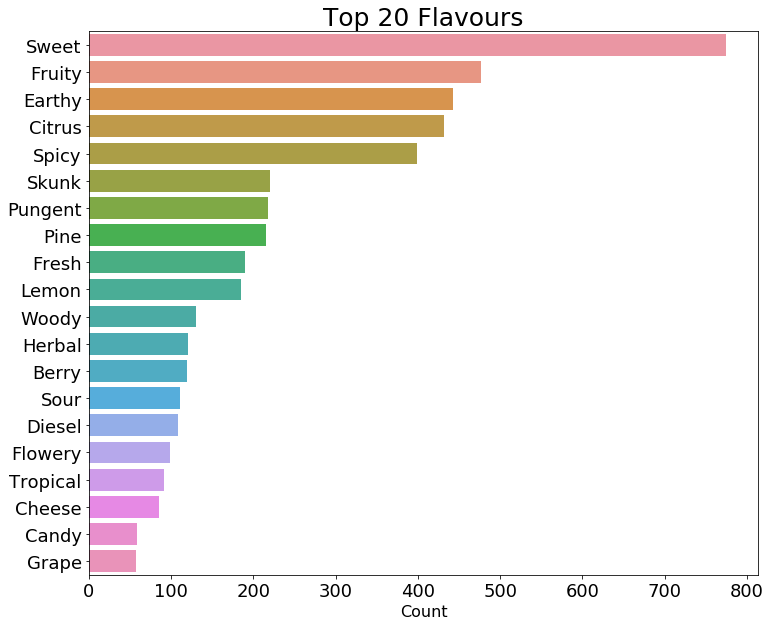

In [21]:
# visualise
y = flavour_total.index.to_list()
x = flavour_total.values

# plot the effects. 
plt.figure(figsize=(12,10))
sns.barplot(x=x, y=y,orient='h')
plt.yticks(fontsize=18)
plt.xlabel('Count', fontsize=16)
plt.xticks(fontsize=18)
plt.title('Top 20 Flavours', fontsize=25)
plt.show()

### Effects


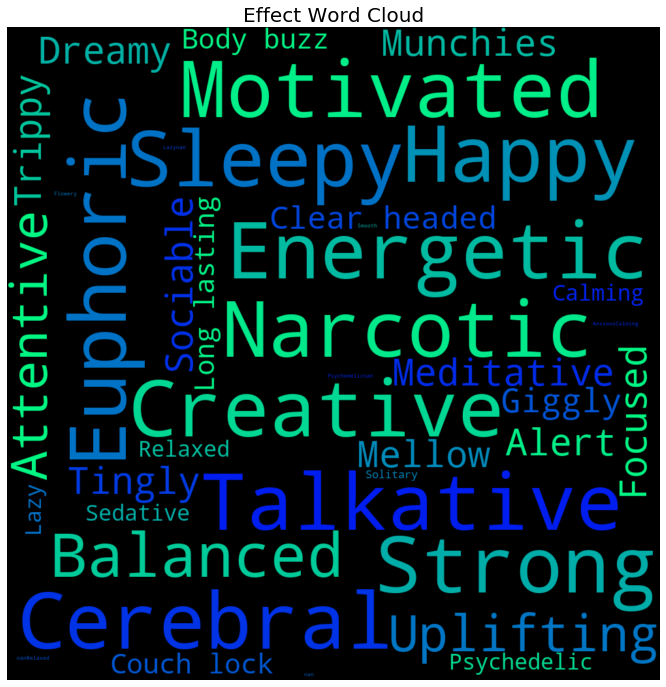

In [22]:
# find unique effects in each column
text1 = " ".join(working_df['effect1'].unique())
text2 = " ".join(working_df['effect2'].unique())
text3 = " ".join(working_df['effect3'].unique())
text4 = " ".join(working_df['effect4'].unique())
text5 = " ".join(working_df['effect5'].unique())

# group text strings together to produce wordcloud
text = (text1 + text2 + text3 + text4 + text5)
# setup stopwords
stopwords = set(STOPWORDS)
stopwords.update(["None","none"])

# create word cloud for effects words
wordcloud = WordCloud(width=1000,
                      height=1000,
                      stopwords=stopwords,
                      colormap='winter',
                      relative_scaling=1.0,
                      max_font_size=120).generate(text)

# Display the generated image:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Effect Word Cloud", fontsize=20)
plt.axis("off")
plt.show()

In [23]:
# create crosstabs of each effect column to sum the counts
ct_e1 = pd.crosstab(working_df['type'], working_df['effect1'])
ct_e2 = pd.crosstab(working_df['type'], working_df['effect2'])
ct_e3 = pd.crosstab(working_df['type'], working_df['effect3'])
ct_e4 = pd.crosstab(working_df['type'], working_df['effect4'])
ct_e5 = pd.crosstab(working_df['type'], working_df['effect5'])

# put the crosstab results into a dataframe
effects_type_df = pd.concat([ct_e1, ct_e2, ct_e3, ct_e4, ct_e5], axis=0,\
                             ignore_index=False,\
                             keys=['1','2','3','4','5'],\
                             names=['Effect', 'Plant Type'])

# drop the NaN values
effects_type_df.drop(['nan'], axis=1, inplace=True)

effects_type_df.fillna(0, inplace=True)

effects_total = effects_type_df.groupby('Effect').sum().sum().sort_values(ascending=False).head(20)

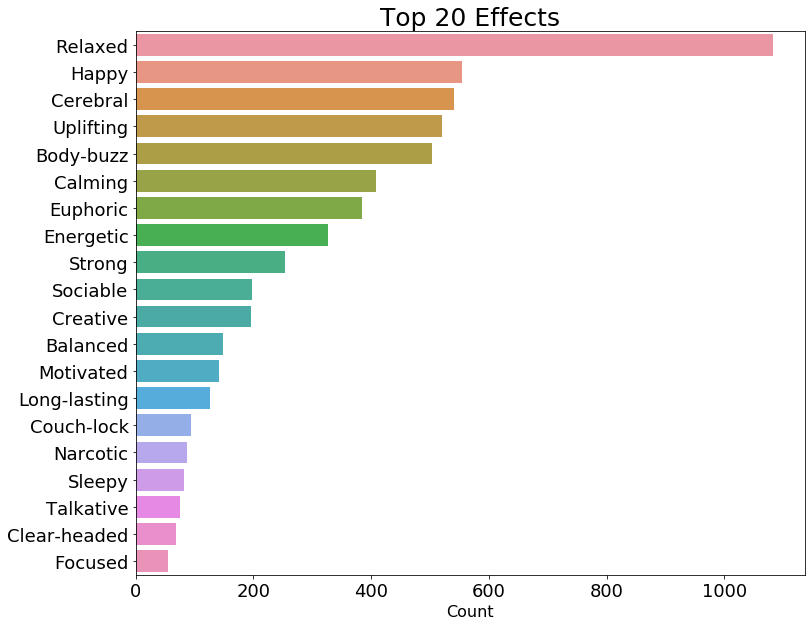

In [24]:
y = effects_total.index.to_list()
x = effects_total.values
colors = ['deeppink','firebrick','coral', 'orange','khaki','mediumseagreen', 'cadetblue', 'dodgerblue', 'orchid', 'sandybrown']
# plot the effects. 
plt.figure(figsize=(12,10))
sns.barplot(x=x, y=y,orient='h')
plt.yticks(fontsize=18)
plt.xlabel('Count', fontsize=16)
plt.xticks(fontsize=18)
plt.title('Top 20 Effects', fontsize=25)
plt.show()

### Growing Properties


#### Grow Type

In [25]:
# growing type
working_df['grow_type'].value_counts()

Photoperiod      1234
Autoflowering     383
Name: grow_type, dtype: int64

#### Flowering Length in Weeks

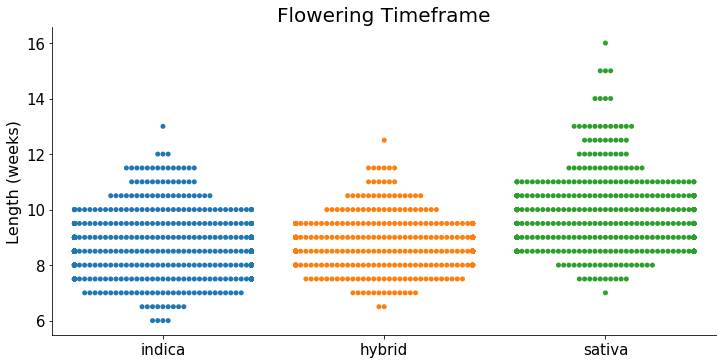

In [26]:
sns.catplot(x='type', y='weeks_to_flower', data=working_df, kind='swarm', aspect=2)
plt.title("Flowering Timeframe", size=20)
plt.xlabel(xlabel=None)
plt.xticks(size=15)
plt.ylabel('Length (weeks)', size=16)
plt.yticks(size=15)
plt.show()

##### Analysis - Growing Traits

The average amount of weeks it takes to grow a plant is 9. It appears that Sativa plants take slightly longer to grow 8 - 13 weeks, while indicas grow during a short time frame of 6-10 weeks

Hybrids fall around the 7-11 week range.

### Preprocessing

Before I can model my data, I need to preprocess a few columns. 
- `Plant Type` : LabelEncoder
- `Effects & Flavours` : DummyVariables
- `Growing Type`: LabelBinarizer

In [27]:
# drop the strain column, we don't need it for the model. 
working_df.drop('strain', axis=1, inplace=True)

In [28]:
# Label Encode the target column
from sklearn.preprocessing import LabelEncoder

# instantiate encoder
le = LabelEncoder()

# fit and transform on plant type column
le.fit(working_df['type'])

working_df['type'] = le.transform(working_df['type'])

In [29]:
# binarize the grow_type column
# 1 - photoperiod
# 0 - autoflowering
from sklearn.preprocessing import LabelBinarizer

# instantiate encoder
lb = LabelBinarizer()

# fit on grow_type column
lb.fit(working_df['grow_type'])

# transform
working_df['grow_type'] = lb.transform(working_df['grow_type'])

In [30]:
# create DF for flavours and effects
ef = working_df.iloc[:, 3:11]

In [31]:
# create dummy dataframe of effects and flavours
ef = pd.get_dummies(ef,dummy_na=False)

In [32]:
# drop any nan columns 
ef.drop(['effect2_nan', 'effect3_nan', 'effect4_nan', \
         'flavour2_nan', 'flavour3_nan','flavour4_nan'], axis=1, inplace=True)

In [33]:
# drop old flavor and effects columns to replace with dummy dataframe
new_df = working_df.drop(['flavour1','flavour2', 'flavour3', 'flavour4', 'effect1', 'effect2', 'effect3', 'effect4','effect5'], axis=1)

In [34]:
# create final dataframe by merging our original and dummy dataframes.
final_df = pd.merge(new_df, ef, left_index=True, right_index=True)

In [35]:
# exporting to csv for back up and future use if needed!
final_df.to_csv('final_canna.csv')

## Modeling
<a id=model></a>

I've set up the dataframe as needed - now I can do some modeling

1. Set up the X and y variables. 
2. Split data into remainder and test sets
3. Run baseline tests using Logistic Regression, KNeighbors Classifier, Support Vector and DecisionTree
4. Split the remainder into train and validation sets
5. Run hyperoptimization on validation set to fine tune the models
5. Re-run the models and score on test set for final accuracy. 

In [36]:
# first set up X and y
X = final_df.iloc[:,1:]
y = final_df['type']

In [37]:
print(y.shape)

(1617,)


In [42]:
from sklearn.model_selection import train_test_split

# Split the data into remainder and test sets
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Print info on how the data has been split
print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

The remainder set has 1131 data points.
The test set has 486 data points.


In [48]:
# Baseline logistic regression
from sklearn.linear_model import LogisticRegression
# Instantiate and fit to the remainder set
baseline_logreg = LogisticRegression(random_state=1, max_iter=1000).fit(X_rem, y_rem)

# Print the accuracies
print(f'Accuracy on remainder set: {baseline_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {baseline_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.8187444739168878
Accuracy on test set: 0.6481481481481481


In [49]:
# baseline KNN
from sklearn.neighbors import KNeighborsClassifier
# instantiate KNeighborsClassifier
baseline_knn = KNeighborsClassifier()

# fit to x_rem and y_rem
baseline_knn.fit(X_rem, y_rem)

# Print the accuracies
print(f'Accuracy on remainder set: {baseline_knn.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {baseline_knn.score(X_test, y_test)}')

Accuracy on remainder set: 0.7303271441202476
Accuracy on test set: 0.6172839506172839


In [50]:
# baseline SVM
from sklearn.svm import SVC
# instantiate SVM
baseline_svm = SVC(random_state=1)
# fit on remainder
baseline_svm.fit(X_rem, y_rem)
# Score and print accuracies
print(f"Accuracy on remainder set: {baseline_svm.score(X_rem, y_rem)}")
print(f"Accuracy on test set: {baseline_svm.score(X_test, y_test)}")

Accuracy on remainder set: 0.6648983200707339
Accuracy on test set: 0.6502057613168725


In [51]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
# instantiate baseline decision tree
baseline_dtree = DecisionTreeClassifier(random_state=1)
# fit to remainder
baseline_dtree.fit(X_rem, y_rem)
# score and print accuracies
print(f"Accuracy on remainder set: {baseline_dtree.score(X_rem, y_rem)}")
print(f"Accuracy on test set: {baseline_dtree.score(X_test, y_test)}")

Accuracy on remainder set: 1.0
Accuracy on test set: 0.5761316872427984


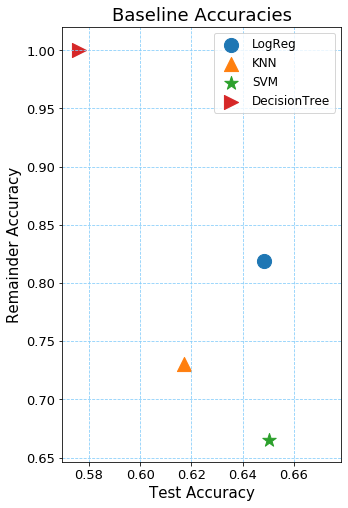

In [54]:
plt.figure(figsize=(5,8))
plt.scatter(baseline_logreg.score(X_test, y_test), baseline_logreg.score(X_rem, y_rem), marker='o', label="LogReg", s=200)
plt.scatter(baseline_knn.score(X_test, y_test), baseline_knn.score(X_rem, y_rem), marker='^', label='KNN', s=200)
plt.scatter(baseline_svm.score(X_test, y_test), baseline_svm.score(X_rem, y_rem), marker='*', label='SVM', s=200)
plt.scatter(baseline_dtree.score(X_test, y_test), baseline_dtree.score(X_rem, y_rem), marker='>', label='DecisionTree', s=200)
plt.xlabel("Test Accuracy", fontsize=15)
plt.xticks(size=13)
plt.ylabel("Remainder Accuracy", fontsize=15)
plt.yticks(size=13)
plt.title('Baseline Accuracies', fontsize=18)
plt.legend(fontsize='large')
plt.grid(b=True,ls='--', color='lightskyblue')
plt.show()

After running the baseline models, it looks like Logistic Regression and SVM provided the best performance before optimizing the parameters. Let's take a look at optimizing these two models to see if we can improve the model performance. 

### Model Hyper-optimization

1. Logistic Regression
2. Support Vector

Now that we've run the baseline tests, I'm going to move forward with optimizing the LogisticRegression and SVM parameters using a pipeline 

In [55]:
# Split the remainder set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2, random_state=1, stratify=y_rem)

# Print info on how the data has been split
print(f'The train set has {len(X_train)} data points.')
print(f'The validation set has {len(X_val)} data points.')

The train set has 904 data points.
The validation set has 227 data points.


In [56]:
# let's check proportions to see if they have been preserved during the splits
print('Proportions in original data:')
print(y.value_counts()/len(y), '\n')

print('Proportions in remainder set:')
print(y_rem.value_counts()/len(y_rem), '\n')

print('Proportions in test set:')
print(y_test.value_counts()/len(y_test), '\n')

print('Proportions in train set:')
print(y_train.value_counts()/len(y_train), '\n')

print('Proportions in validation set:')
print(y_val.value_counts()/len(y_val), '\n')

Proportions in original data:
1    0.439085
2    0.293135
0    0.267780
Name: type, dtype: float64 

Proportions in remainder set:
1    0.439434
2    0.292661
0    0.267905
Name: type, dtype: float64 

Proportions in test set:
1    0.438272
2    0.294239
0    0.267490
Name: type, dtype: float64 

Proportions in train set:
1    0.439159
2    0.293142
0    0.267699
Name: type, dtype: float64 

Proportions in validation set:
1    0.440529
2    0.290749
0    0.268722
Name: type, dtype: float64 



In [57]:
# Let's try a modest range of C values
c_values = [.00001, .0001, .001, .1, 1, 10, 100, 1000, 10000]

# Set up empty lists
train_accuracies = []
validation_accuracies = []

# Iterate over the C values
for value in c_values:
    
    # Instantiate a log reg 
    logreg = LogisticRegression(C=value, random_state=1, max_iter=1000)
    
    # fit on training set
    logreg.fit(X_train, y_train)
    
    # Score on the train set and append this accuracy to its respective list
    train_accuracies.append(logreg.score(X_train, y_train))
    
    # Score on the validation set and append this accuracy to its respective list
    validation_accuracies.append(logreg.score(X_val, y_val))

/Users/lizzy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/lizzy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

In [58]:
# Check the accuracies
pd.DataFrame({'C value': c_values, 'train accuracy': train_accuracies, 'validation accuracy': validation_accuracies})

,C value,train accuracy,validation accuracy
0,0.00001,0.439159,0.440529
1,0.00010,0.439159,0.440529
2,0.00100,0.500000,0.502203
3,0.10000,0.736726,0.651982
4,1.00000,0.831858,0.607930
5,10.00000,0.882743,0.599119
6,100.00000,0.905973,0.581498
7,1000.00000,0.914823,0.585903
8,10000.00000,0.913717,0.577093


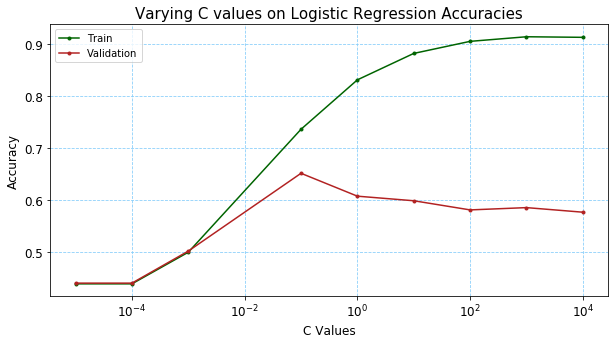

In [59]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(c_values, train_accuracies, label='Train', marker='.', color='darkgreen')
plt.plot(c_values, validation_accuracies, label='Validation', marker='.', color='firebrick')
plt.legend()
plt.title('Varying C values on Logistic Regression Accuracies', size=15)
plt.xscale('log') # Put the x-axis on a log scale; this is important because the C values vary in orders of magnitude
plt.xlabel('C Values', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid(ls='--', color='lightskyblue')
plt.show()

We pick a value of C that yields the highest validation accuracy without the train accuracy being too high (which would indicate overfitting). Based on the above, let's choose a C value of 0.1, build a final model, and score on the remainder and test sets.

In [60]:
# Instantiate a log reg and fit to the remainder set
validated_logreg = LogisticRegression(C=0.1, random_state=1, max_iter=1000)

# fit on X_rem, y_rem
validated_logreg.fit(X_rem, y_rem)

# Score and print the accuracies
print(f'Accuracy on remainder set: {validated_logreg.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {validated_logreg.score(X_test, y_test)}')

Accuracy on remainder set: 0.7391688770999116
Accuracy on test set: 0.6851851851851852


In [61]:
from sklearn.neighbors import KNeighborsClassifier

knn_train_acc, knn_val_acc = [], []

# set up range of neighbors
n_neighbors = np.arange(1,52,2)

for n in n_neighbors:
    # instantiate KNN models
    my_knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)

    # fit the models
    my_knn.fit(X_train, y_train)
    
    # score and append to lists
    knn_train_acc.append(my_knn.score(X_train, y_train))
    knn_val_acc.append(my_knn.score(X_val, y_val))

In [62]:
# Check the accuracies
pd.DataFrame({'Number of Neighbours': n_neighbors, 'train accuracy': knn_train_acc, 'validation accuracy': knn_val_acc})

,Number of Neighbours,train accuracy,validation accuracy
0,1,1.000000,0.585903
1,3,0.761062,0.607930
2,5,0.716814,0.651982
3,7,0.689159,0.665198
4,9,0.674779,0.665198
5,11,0.679204,0.656388
6,13,0.660398,0.638767
7,15,0.652655,0.634361
8,17,0.646018,0.643172
9,19,0.632743,0.638767


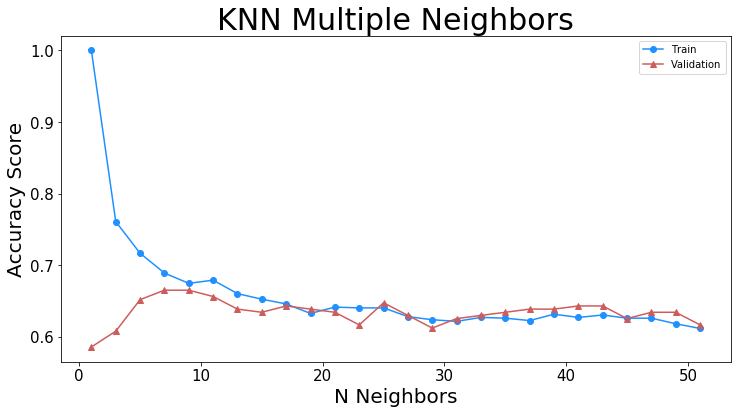

In [63]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(n_neighbors, knn_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(n_neighbors, knn_val_acc, marker='^', color='indianred', label='Validation')
plt.xlabel('N Neighbors', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('KNN Multiple Neighbors', size=30)
plt.legend()
plt.show()

In [64]:
from sklearn.svm import SVC
svm_train_acc, svm_val_acc = [], []

kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for k in kernels:
    # instantiate
    my_SVM = SVC(kernel=k)
    # Fit
    my_SVM.fit(X_train, y_train)
    # score and append
    svm_train_acc.append(my_SVM.score(X_train, y_train))
    svm_val_acc.append(my_SVM.score(X_val, y_val))

In [65]:
pd.DataFrame({'Kernel': kernels, 'train accuracy': svm_train_acc, 'validation accuracy': svm_val_acc})

,Kernel,train accuracy,validation accuracy
0,linear,0.842920,0.634361
1,poly,0.675885,0.634361
2,rbf,0.653761,0.643172
3,sigmoid,0.449115,0.453744


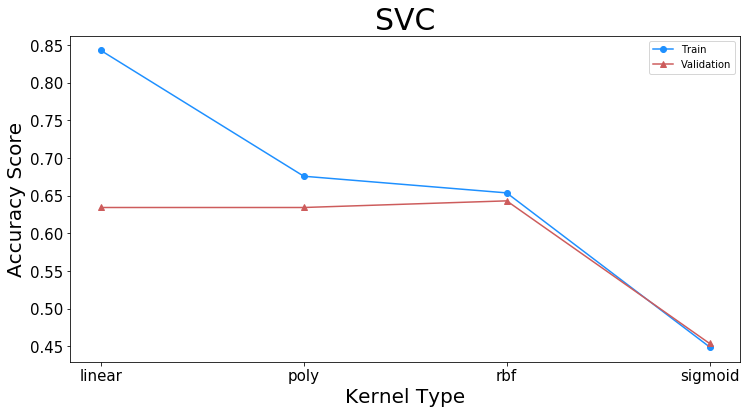

In [66]:
# visualize the results
plt.figure(figsize=(12,6))
plt.plot(kernels, svm_train_acc, marker='o', color='dodgerblue', label='Train')
plt.plot(kernels, svm_val_acc, marker='^', color='indianred', label='Validation')
plt.xlabel('Kernel Type', size=20)
plt.xticks(size=15)
plt.ylabel('Accuracy Score', size=20)
plt.yticks(size=15)
plt.title('SVC', size=30)
plt.legend()
plt.show()

### GridSearch and Pipeline

In [69]:
# Import everything again (for completeness)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
# Make the pipeline
# Note that this is more of a placeholder, grid search will only look over the values
# in the param grid, this more to setup the pipeline step names

estimators = [('scaling', MinMaxScaler()),
              ('dimensionality', PCA()),
              ('model', LogisticRegression())]

pipe = Pipeline(estimators)

param_grid = [
{'scaling':[StandardScaler(), None], 
 'dimensionality':[PCA()],
 'model': [LogisticRegression()],
  'dimensionality__n_components':[100, 300, 400, 500],
 'model__C':np.power(10.0, np.arange(-3, 3))},
    
{'scaling':[StandardScaler(), None], 
 'dimensionality':[PCA()],
 'model': [SVC()],
  'dimensionality__n_components':[100, 300, 400, 500],
 'model__C':np.power(10.0, np.arange(-3, 3)),
'model__kernel':['rbf','linear','sigmoid'],
'model__gamma':[1, 10, 100]},
    
{'scaling':[StandardScaler(), None], 
 'dimensionality':[None],
 'model': [KNeighborsClassifier()],
 'model__n_neighbors':np.arange(1, 11)}
]
grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed: 27.6min finished


In [70]:
# What is the best pipeline?
fittedgrid.best_estimator_

Pipeline(memory=None,
         steps=[('scaling', None),
                ('dimensionality',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('model',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=10, kernel='linear', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [71]:
# Score
fittedgrid.score(X_test, y_test)

0.6666666666666666

### Summary

I was curious to see if using a pipeline and cross validation would give me better model performance but it did not. 

It appears that LogisticRegression with a c_value of 0.1 produces the best results with respects to this dataset.
I'm happy with the results of my model ~70% accuracy classifying strains. 

In the future I would like to take this further and do some unsupervised learning to see if there are any additional underlying patterns or trends in the data. 

The second step I'd like to do is create a recommendation system. I believe that I would need to increase my database but I'll start out with the 1600 strains I have currently. 

There were some distinctions between plant types. Indicas were typically more sleepy, relaxing while sativas offer a more uplifting and energetic experience. The flavour profiles varied across strains, but the majority had citrus, sweet and pungent flavours. Hybrids are a cross between both so I expected the effects and flavours to be a combination of indica/sativa. 

